# Stellar Classification Dataset - SDSS17

The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar. **DATA IS ALREADY CLEAN**.

**NOTE!!** Notebook is not optimized!! Some code blocks might take 1-3 minutes to run.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import _euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

**obj_ID** = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS

**alpha** = Right Ascension angle (at J2000 epoch)

**delta** = Declination angle (at J2000 epoch)

**u** = Ultraviolet filter in the photometric system

**g** = Green filter in the photometric system

**r** = Red filter in the photometric system

**i** = Near Infrared filter in the photometric system

**z** = Infrared filter in the photometric system

**run_ID** = Run Number used to identify the specific scan

**rereun_ID** = Rerun Number to specify how the image was processed

**cam_col** = Camera column to identify the scanline within the run

**field_ID** = Field number to identify each field

**spec_obj_ID** = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)

**class** = object class (galaxy, star or quasar object)

**redshift** = redshift value based on the increase in wavelength

**plate** = plate ID, identifies each plate in SDSS

**MJD** = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

**fiber_ID** = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [2]:
file_name = "star_classification.csv"
df  = pd.read_csv(file_name, sep=',')

## Dataset

In [3]:
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

**0** is GALAXY
**1** is STAR
**2** is QSO

In [6]:
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

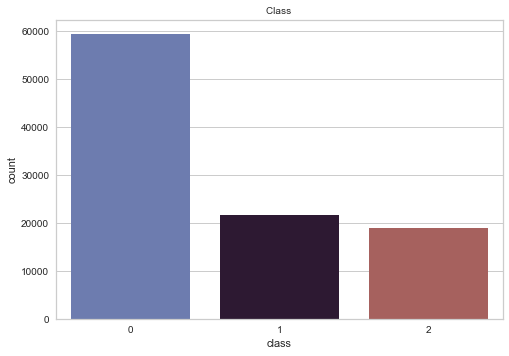

In [7]:
sns.countplot(x=df["class"], palette="twilight")
plt.title("Class ",fontsize=10)
plt.show()

## Outliers and Feature Selection

This takes a minute or so to run. The Local Outlier Factor (**LOF**) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [8]:
lof = LocalOutlierFactor()
y_pred = lof.fit_predict(df)
x_score = lof.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

threshold = -1.5                                            
filter1 = outlier_score["score"] < threshold
outlier_index = outlier_score[filter1].index.tolist()
len(outlier_index)


15256

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  int64  
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(8)


In [10]:
df.drop(outlier_index, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84744 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       84744 non-null  float64
 1   alpha        84744 non-null  float64
 2   delta        84744 non-null  float64
 3   u            84744 non-null  float64
 4   g            84744 non-null  float64
 5   r            84744 non-null  float64
 6   i            84744 non-null  float64
 7   z            84744 non-null  float64
 8   run_ID       84744 non-null  int64  
 9   rerun_ID     84744 non-null  int64  
 10  cam_col      84744 non-null  int64  
 11  field_ID     84744 non-null  int64  
 12  spec_obj_ID  84744 non-null  float64
 13  class        84744 non-null  int64  
 14  redshift     84744 non-null  float64
 15  plate        84744 non-null  int64  
 16  MJD          84744 non-null  int64  
 17  fiber_ID     84744 non-null  int64  
dtypes: float64(10), int64(8)
memory usage: 12.3 MB

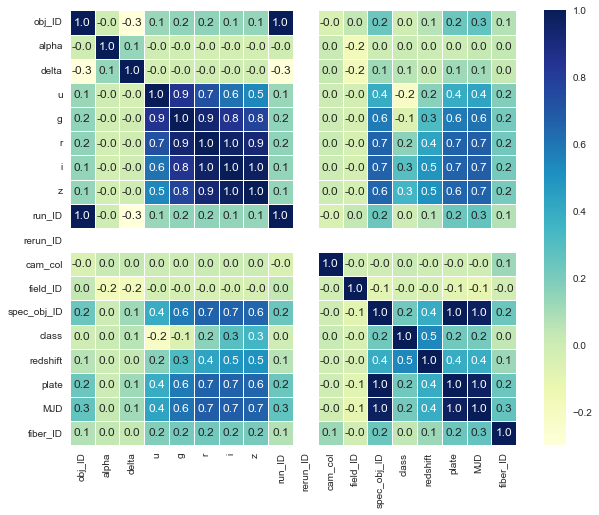

In [12]:
features,ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(),cmap="YlGnBu", annot=True, fmt='.1f',linewidths=0.5,ax=ax)
plt.show()

In [13]:
correlation = df.corr()
correlation["class"].sort_values()

u             -0.222756
g             -0.058155
field_ID      -0.037529
run_ID         0.000245
obj_ID         0.000247
alpha          0.008183
cam_col        0.017749
fiber_ID       0.037349
delta          0.058952
r              0.160680
MJD            0.214441
spec_obj_ID    0.224728
plate          0.224729
i              0.294096
z              0.349730
redshift       0.541684
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

Get rid of unwanted columns? ID's, cam_col and alpha and delta I'd say? Spec_obj_ID can be kept as unique object id? So we know if its the same object or not

In [14]:
df = df.drop(['field_ID','run_ID','obj_ID','fiber_ID','rerun_ID','alpha','delta','cam_col'],axis=1)

## Imbalanced Data

As we can see in the above cells Class 0 has way more entries than Class 1 or 2. We have to deal with that if we want to take the resulting accuracy value for what it is. It could also lead to overfitting. We can either under- or oversample. I went with oversampling, aka. resampling the minority class, since undersampling can lead to underfitting.

In [15]:
x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

In [16]:
smote = SMOTE(random_state=42)
print('Original %s' % Counter(y))
x, y = smote.fit_resample(x, y)
print('Resampled %s' % Counter(y))

Original Counter({0: 50696, 1: 17890, 2: 16158})
Resampled Counter({0: 50696, 2: 50696, 1: 50696})


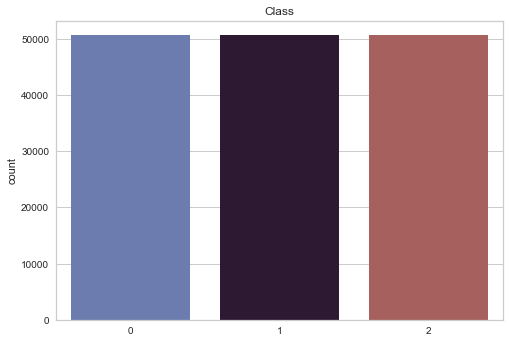

In [17]:
sns.countplot(x=y, palette="twilight")
plt.title("Class")
plt.show()

**TADAA** fixed.

## Feature Scaling

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step. Just to give you an example — if you have multiple independent variables like age, salary, and height; With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range, for example- centered around 0 or in the range (0,1) depending on the scaling technique

In [18]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

## Train and Test

This is the splitting section. I'll do it randomly and since I already did proper preprocessing this is totally fine. It is often recommend that your test set should be about 25% the size of your training set. Also since popular integer random seeds are 0 and 42, and since people working with this data set often used 42, I will do the same to compare my results.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

## SVM Classifier

Support Vector Machines (**SVM**s in short) are machine learning algorithms that are used for classification and regression purposes. SVMs are one of the powerful machine learning algorithms for classification, regression and outlier detection purposes. An SVM classifier builds a model that assigns new data points to one of the given categories. Thus, it can be viewed as a non-probabilistic binary linear classifier.

In [20]:
svm = svm.SVC(kernel='rbf', C=1, random_state = 42)
svm.fit(x_train,y_train)
predicted = svm.predict(x_test)
score = svm.score(x_test, y_test)
svm_score = np.mean(score)

print('Accuracy : %.3f' % (svm_score))

Accuracy : 0.972


### Performance

Quick cross-validation check (okay maybe not that quick, even with `n_jobs` set to -1, which means use all CPU cores). Fold is set once; different splits of data = folds.

In [21]:
fold = StratifiedKFold(n_splits=4, shuffle = True, random_state=42)
cross_val = cross_val_score(svm,x,y,cv=fold,n_jobs=-1)
print(np.mean(cross_val))

0.9701817368891694


A confusion matrix is a technique for summarizing the performance of a classification algorithm.
Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making

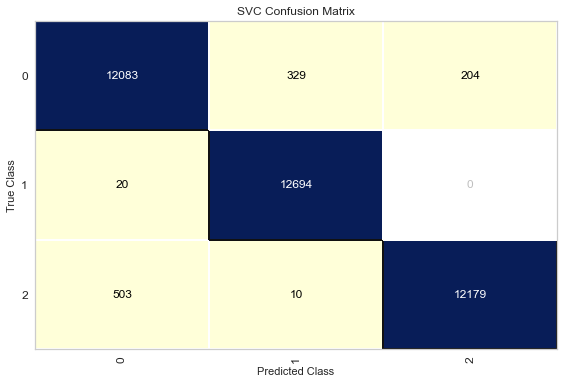

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [22]:
svm_cm = ConfusionMatrix(svm, cmap="YlGnBu")
svm_cm.fit(x_train,y_train)
svm_cm.score(x_test,y_test)
svm_cm.show()

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate.

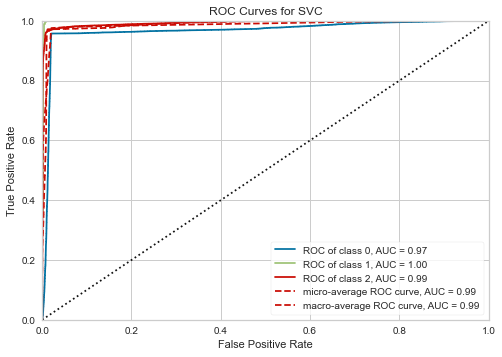

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
svm_roc_curve = ROCAUC(svm)
svm_roc_curve.fit(x_train,y_train)
svm_roc_curve.score(x_test,y_test)
svm_roc_curve.show()

In [24]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12616
           1       0.97      1.00      0.99     12714
           2       0.98      0.96      0.97     12692

    accuracy                           0.97     38022
   macro avg       0.97      0.97      0.97     38022
weighted avg       0.97      0.97      0.97     38022



## LightGBM

LightGBM is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks. A decision tree algorithm is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome. In a Decision tree, there are two nodes, which are the Decision Node and Leaf Node.

In [25]:
lightgbm = LGBMClassifier(random_state=42)
lightgbm.fit(x_train,y_train)
predicted = lightgbm.predict(x_test)
score = lightgbm.score(x_test,y_test)
lightgbm_score = np.mean(score)

print('Accuracy : %.3f' % (lightgbm_score))

Accuracy : 0.981


### Performance

Quick cross-validation check (okay maybe not that quick, even with n_jobs set to -1, which means use all CPU cores)

In [26]:
cross_val = cross_val_score(lightgbm,x,y,cv=fold,n_jobs=-1)
print(np.mean(cross_val))

0.9804652569564988


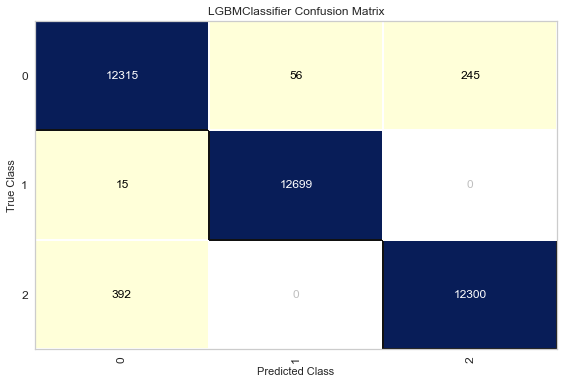

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [27]:
lightgbm_cm = ConfusionMatrix(lightgbm, cmap="YlGnBu")
lightgbm_cm.fit(x_train,y_train)
lightgbm_cm.score(x_test,y_test)
lightgbm_cm.show()

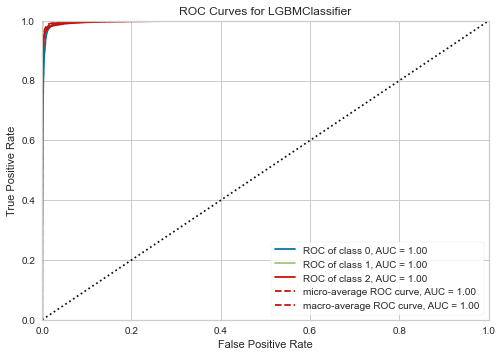

<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
lightgbm_roc_curve = ROCAUC(lightgbm)
lightgbm_roc_curve.fit(x_train,y_train)
lightgbm_roc_curve.score(x_test,y_test)
lightgbm_roc_curve.show()

In [29]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     12616
           1       1.00      1.00      1.00     12714
           2       0.98      0.97      0.97     12692

    accuracy                           0.98     38022
   macro avg       0.98      0.98      0.98     38022
weighted avg       0.98      0.98      0.98     38022



## Random Forest Classifier

As the name suggests, Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.

In [30]:
forest = RandomForestClassifier()
forest.fit(x_train,y_train)
predicted = forest.predict(x_test)
score = forest.score(x_test, y_test)
forest_score = np.mean(score)

print('Accuracy : %.3f' % (forest_score))

Accuracy : 0.985


In [31]:
cross_val = cross_val_score(forest,x,y,cv=fold,n_jobs=-1)
print(np.mean(cross_val))

0.9836015990742202


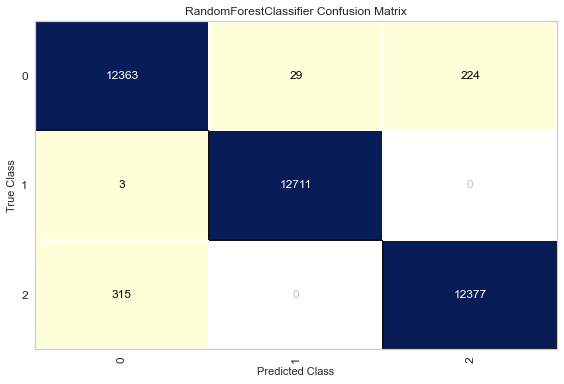

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [32]:
forest_cm = ConfusionMatrix(forest, cmap='YlGnBu')
forest_cm.fit(x_train, y_train)
forest_cm.score(x_test, y_test)
forest_cm.show()

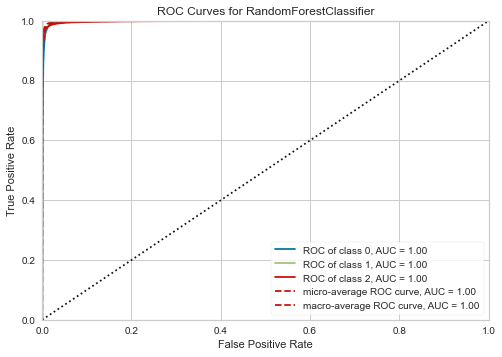

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [33]:
forest_roc_curve = ROCAUC(forest)
forest_roc_curve.fit(x_train,y_train)
forest_roc_curve.score(x_test,y_test)
forest_roc_curve.show()

In [34]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     12616
           1       1.00      1.00      1.00     12714
           2       0.98      0.98      0.98     12692

    accuracy                           0.98     38022
   macro avg       0.98      0.98      0.98     38022
weighted avg       0.98      0.98      0.98     38022

